# Cart-Pole Latent State Observation



In [1]:
import matplotlib.pyplot as plt
import torch
from reservoirpy.nodes import Reservoir, Ridge

In [2]:
from cart_pendulum_measurement import CartPole_measurement
from cart_pendulum_model import CartPole_motion
from controller import Controller

In [3]:
# Change device according to your configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') # feel free to change :)
device = torch.device('cpu') # override
device

device(type='cpu')

## Loading a system module


In [4]:
cartpole = CartPole_motion()
sensor = CartPole_measurement()
cartpole.device = device
sensor.device = device
?? cartpole

Type:        CartPole_motion
String form: <cart_pendulum_model.CartPole_motion object at 0x7e38cae87410>
File:        ~/KASRA/Research/Reservior/Codes/CartPole/cart_pendulum_model.py
Source:     
class CartPole_motion():
    '''Continuous version of the OpenAI Gym cartpole
    Inspired by: https://gist.github.com/iandanforth/e3ffb67cf3623153e968f2afdfb01dc8'''
    def __init__(self):      
        self.device =  torch.device('cpu') 
        self.gravity = 9.81
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5
        self.polemass_length = (self.masspole * self.length)
        self.model_std = 0
        self.model_mean = 0
        
    def dynamics(self, θ, dθ, u):
        """
        Calculate the continuous equation of motion of the cartpole.

        Parameters:
        ----------
        θ : torch.Tensor
            Current pole's angle.
        dθ : torch.Tensor
            Current pole's ang

## Initial conditions
### Time initial variables:

In [5]:
# Time span
dt = 0.01 # step size
t0, tf = 0, 10 # initial and final time
steps = int((tf - t0)/dt) 
t_span = torch.linspace(t0, tf, steps).to(device)

### Initial States variables:

In [6]:
# Initial distribution
θ_0 = 1; θ_d_0 = 0.1
x_0 = 1; x_d_0 = 0.1

state_number = 4
obs_number = 4
states = torch.zeros(steps, state_number, 1).to(device)
accel = torch.zeros(steps, 2, 1).to(device)

measure = torch.zeros(steps, obs_number,1 ).to(device)

# Noise uniform distribution function 
init_dist = torch.distributions.Uniform\
    (torch.Tensor([-θ_0, -x_0, -θ_d_0, -x_d_0]), torch.Tensor([θ_0,  x_0, θ_d_0, x_d_0]))

states[0]  = init_dist.sample((1,)).T.to(device)
states.size()

# Process(model) noise 
model_mean, sensor_mean  = 0, 0
model_std , sensor_std = 0.0 , 0.0

cartpole.model_mean = model_mean
cartpole.model_std  = model_std

# Measurement(sensor) noise
sensor.std = sensor_std
sensor.mean = sensor_mean
sensor.bias = 0


# Controller Initialization:
Simple PID controller

In [7]:
controller = Controller()
controller.P = 2
controller.I = 10
controller.D = 1

controller.a = 1
controller.b = 5
controller.dt = dt

controller.angle_setpoint = 0
controller.pos_setpoint = 0
        
u = torch.zeros(steps, 1, 1).to(device)
integralE , totalE= u.clone().detach().to(device), u.clone().detach().to(device)




# States Propagation:
Close Loop system in descrete time 

Text(0, 0.5, 'x (m)')

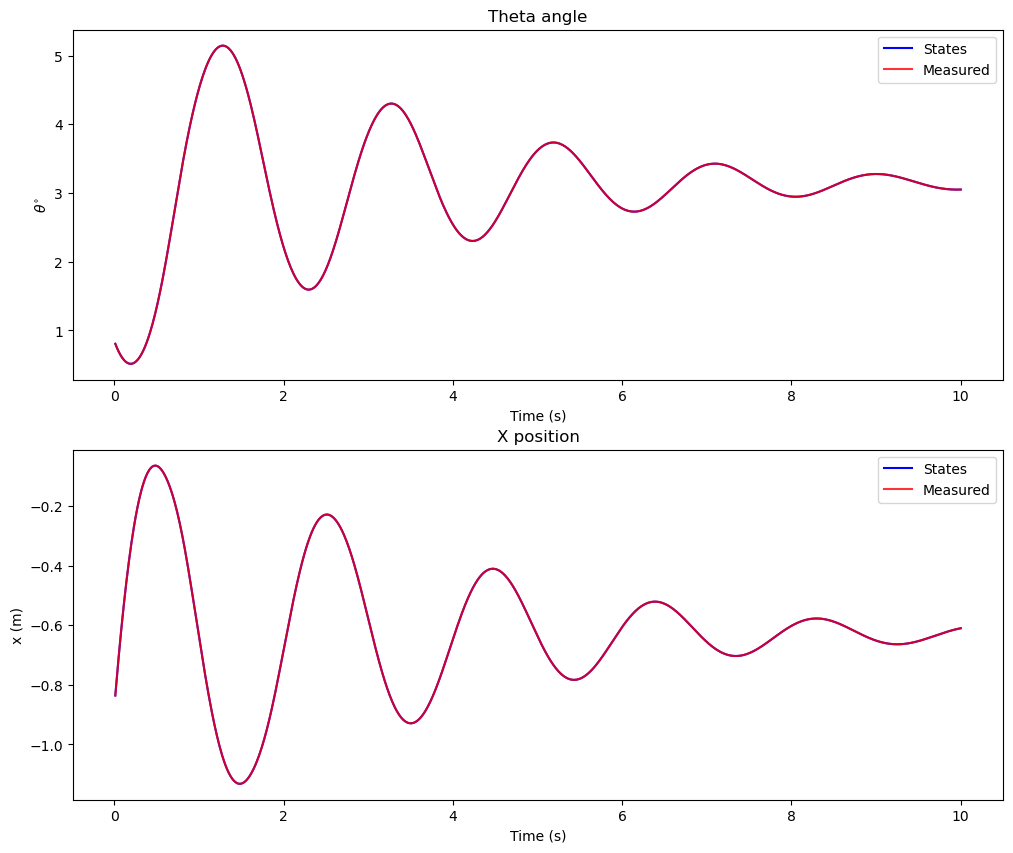

In [8]:

for i in range(0,steps-1):      
    # Control signal:  
    u[i],totalE[i+1], integralE[i+1]  = controller.PID(states[i], totalE[i], integralE[i] )
    
    # System dynamics output as motion: 
    motion = cartpole.motion_model(states[i, :2], states[i, 2:], u[i], dt)     
    
    # Separating States(pos, velocity) from acceleration 
    states[i+1, :2] , states[i+1, 2:], accel[i+1]  = motion[0:2], motion[2:4], motion[4:5]  
    
    # system response measurement(Full observable with IMU)   
    measure[i+1] = sensor.statemeter(states[i+1])        
       

fig, axs = plt.subplots(2,1, figsize=(12,10))
axs[0].plot(t_span[1:].detach().cpu(), states[1:,0].detach().cpu(), label='States', color='blue', alpha=1)
axs[0].plot(t_span[1:].detach().cpu(),measure[1:,0].detach().cpu(), label='Measured', color = 'red' , alpha=0.8)
axs[0].legend(); axs[0].set_title('Theta angle')
axs[0].set_xlabel(r'Time (s)'); axs[0].set_ylabel(r'$\theta^{\circ}$')


axs[1].plot(t_span[1:].detach().cpu(),states[1:,1].detach().cpu(), label='States', color='blue', alpha=1)
axs[1].plot(t_span[1:].detach().cpu(), measure[1:,1].detach().cpu(), label='Measured',color = 'red' , alpha=0.8)
axs[1].legend() ;axs[1].set_title('X position')
axs[1].set_xlabel(r'Time (s)') ;axs[1].set_ylabel(r'x (m)')


## Latent State 1
Choosing the latent states and visible ones.
- theta and x are the latent states.
- control inputs and accelerations are visible and measurable

torch.Size([750, 3]) torch.Size([250, 3])
torch.Size([750, 2]) torch.Size([250, 2])


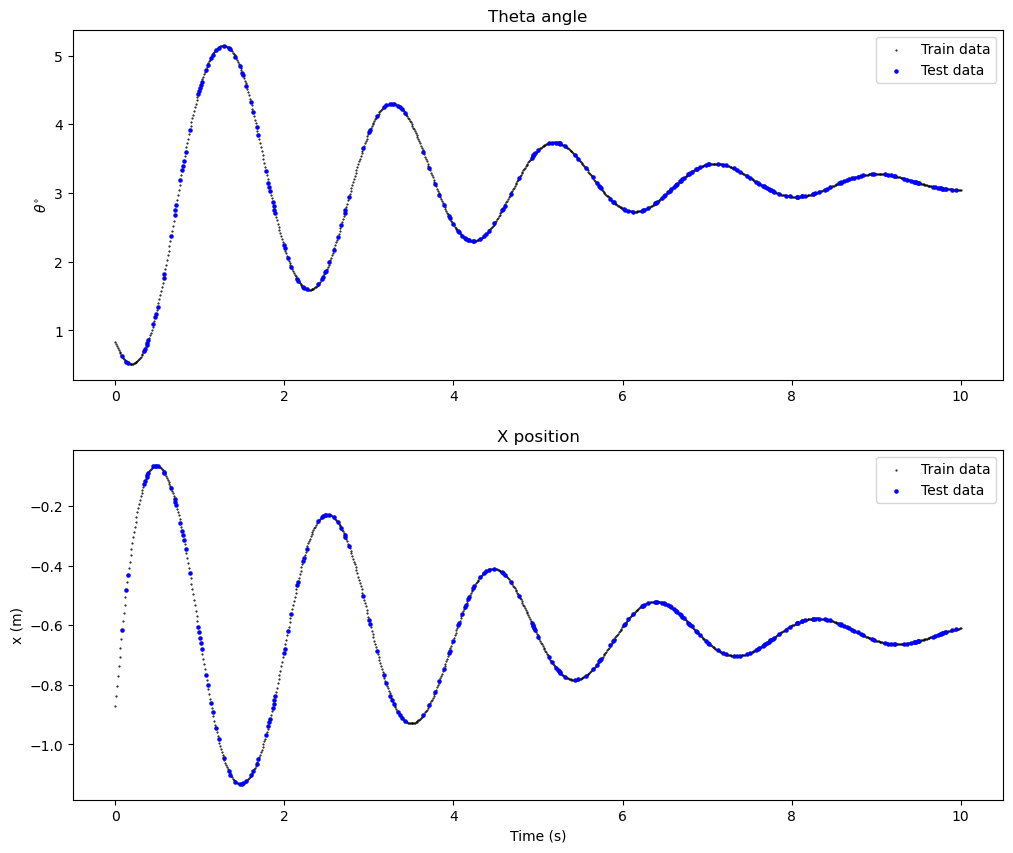

In [9]:
y = states[...,:2, 0].view(-1,2)
x = torch.hstack([u.view(-1,1), accel.view(-1,2)])

total_data = x.size(0)
test_traine_ratio = 0.75
separation_boundry = round(test_traine_ratio * total_data)

## Random Test-Train separation:
randperm = torch.randperm(total_data)
train_idx = randperm[:separation_boundry]
test_idx = randperm[separation_boundry: ]

x_train = x[train_idx]
y_train = y[train_idx]
time_train = t_span[train_idx]

x_test = x[test_idx] 
y_test = y[test_idx]
time_test = t_span[test_idx]

fig, axs = plt.subplots(2,1, figsize=(12,10))
axs[0].scatter(time_train, y_train[...,0],color="black",label="Train data", marker='.',s=1)
axs[0].scatter(time_test, y_test[...,0], color="blue", label="Test data", marker='o', s=5)
axs[0].legend(); axs[0].set_title('Theta angle')
axs[0].set_ylabel(r'$\theta^{\circ}$')

axs[1].scatter(time_train, y_train[...,1],color="black",label="Train data", marker='.',s=1)
axs[1].scatter(time_test, y_test[...,1], color="blue", label="Test data", marker='o', s=5)
axs[1].legend(); axs[1].set_title('X position')
axs[1].set_ylabel(r'x (m)'); axs[1].set_xlabel(r'Time (s)') 

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)


##  Reservoir Creation With Echo State Networks
In ReservoirPy, connecting nodes together leads to the creation of $Model$ objects. Models are a specific type of node containing other nodes, and a description of all the connections between them. When run, a Model will run all the nodes it contains, and make the data follow their declared connections. When trained, it will also take care of training all its readouts.

In [10]:
reservoir1 = Reservoir(1000, lr=0.8, sr=0.8)
readout1 = Ridge(ridge=1e-7)

esn_model1 =  reservoir1 >> readout1

### Train the ESN

Once the Model is created, it can be trained using its $fit()$ method:


In [11]:
esn_model1 = esn_model1.fit(x_train, y_train)

Running Model-0: 750it [00:00, 3952.03it/s]0<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

Fitting node Ridge-0...


ESN model and Reservoir hyperparameters

#### Run over a whole timeseries
Gathering the activations of a node over a timeseries (array with rows representing time axis) can be done with the $run()$ method. This method takes arrays of shape $(timesteps, features)$ as input and returns an array of $(timesteps, states)$ shape.

In [12]:
prediction = esn_model1.run(x_test)

Running Model-0: 250it [00:00, 3999.98it/s]           


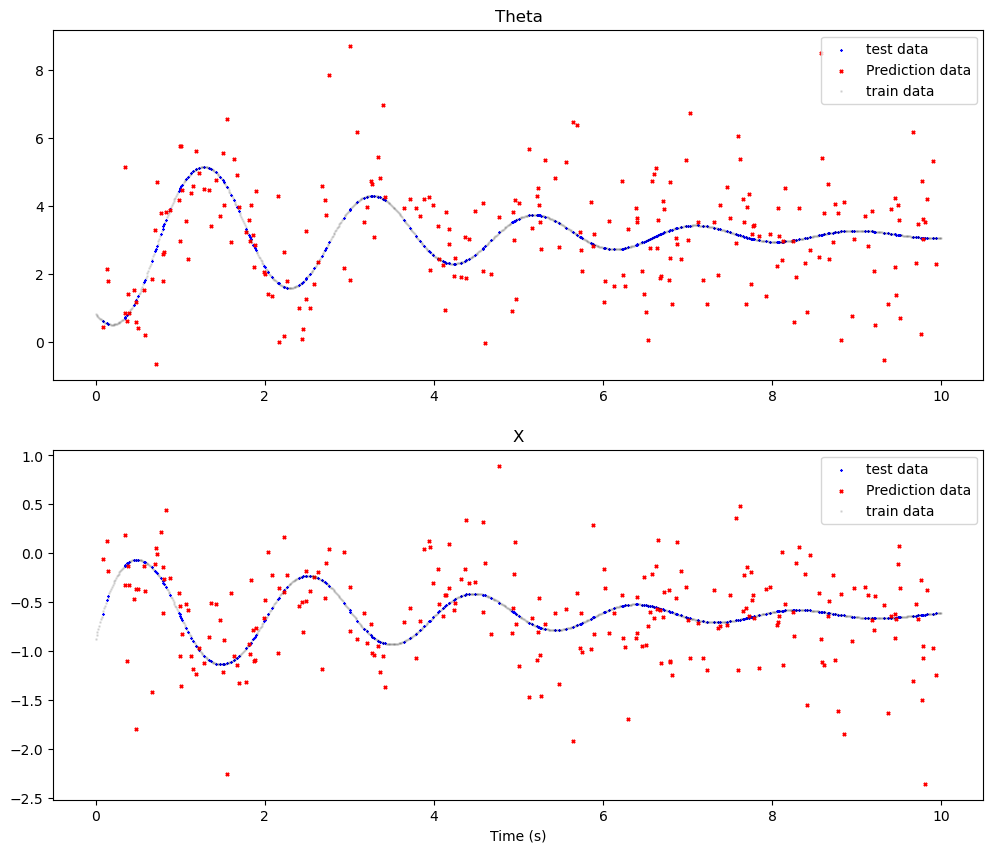

In [13]:
fig, axs = plt.subplots(2,1, figsize=(12,10))
axs[0].scatter(time_test,y_test[...,0],color="blue",label="test data", marker='x',s=1)
axs[0].scatter(time_test,prediction[...,0],color="red",label="Prediction data", marker='x',s=5)
axs[0].scatter(time_train,y_train[...,0],color="black",label="train data",s=1, alpha=0.1)
axs[0].set_title("Theta");  axs[0].legend()

axs[1].scatter(time_test,y_test[...,1],color="blue",label="test data", marker='x',s=1)
axs[1].scatter(time_test,prediction[...,1],color="red",label="Prediction data", marker='x',s=5)
axs[1].scatter(time_train,y_train[...,1],color="black",label="train data",s=1, alpha=0.1)
axs[1].set_title("X"); axs[1].legend()
axs[1].set_xlabel(r'Time (s)');

## Latent State 2
Choosing the latent state and visible ones.
- theta and x are the latent states.
- control inputs, Velocities, and accelerations are visible and measurable

torch.Size([750, 5]) torch.Size([250, 5])
torch.Size([750, 2]) torch.Size([250, 2])


Running Model-1: 750it [00:00, 3862.06it/s]0<?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Fitting node Ridge-1...


Running Model-1: 250it [00:00, 4137.75it/s]           
Running Model-1: 250it [00:00, 4084.61it/s]           


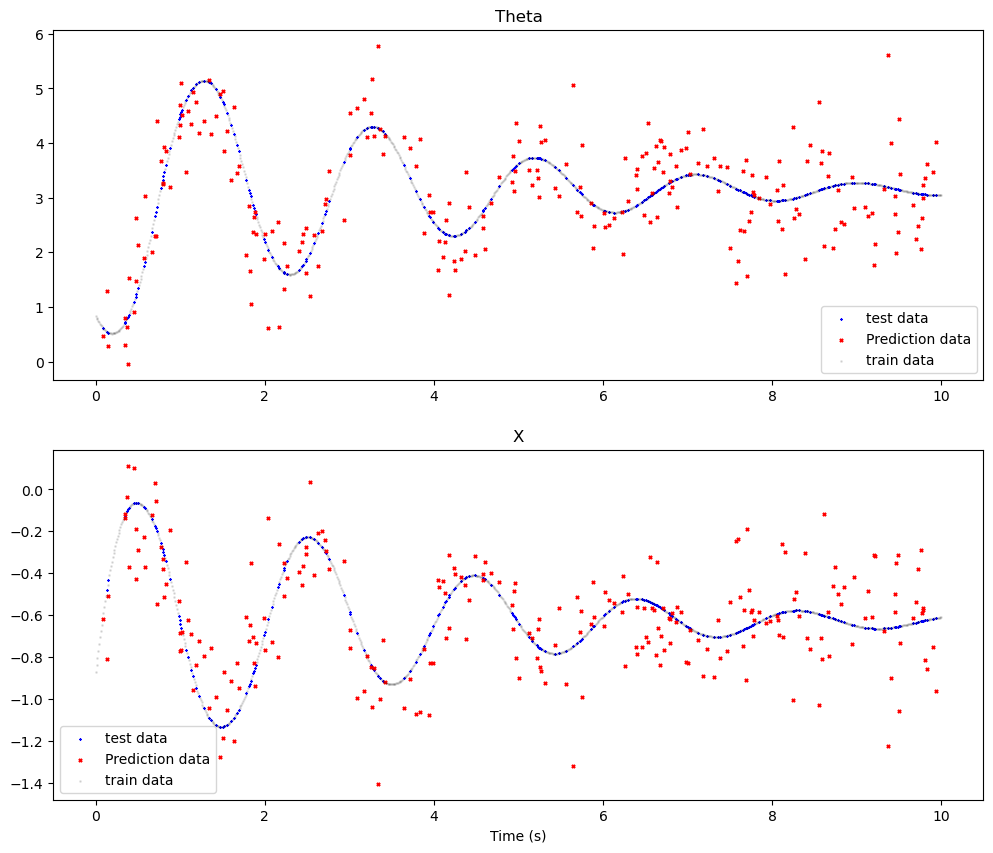

In [14]:
# theta is the latent state in this case
y2 = states[...,:2, 0].view(-1,2)
# control inputs and accelerations are visible and measurable
x2 = torch.hstack([u.view(-1,1), accel.view(-1,2), states[...,2:4,0].view(-1,2)])

x_train2 = x2[train_idx]
y_train2 = y2[train_idx]
time_train = t_span[train_idx]

x_test2 = x2[test_idx] 
y_test2 = y2[test_idx]
time_test = t_span[test_idx]

print(x_train2.shape, x_test2.shape)
print(y_train2.shape, y_test2.shape)

reservoir2 = Reservoir(1000, lr=0.8, sr=0.8)
readout2 = Ridge(ridge=1e-7)

esn_model2 =  reservoir2 >> readout2
esn_model2 = esn_model2.fit(x_train2, y_train2)
prediction2 = esn_model2.run(x_test2)

prediction2 = esn_model2.run(x_test2)

fig, axs = plt.subplots(2,1, figsize=(12,10))
axs[0].scatter(time_test,y_test2[...,0],color="blue",label="test data", marker='x',s=1)
axs[0].scatter(time_test,prediction2[...,0],color="red",label="Prediction data", marker='x',s=5)
axs[0].scatter(time_train,y_train2[...,0],color="black",label="train data",s=1, alpha=0.1)
axs[0].set_title("Theta"); axs[0].legend()

axs[1].scatter(time_test,y_test2[...,1],color="blue",label="test data", marker='x',s=1)
axs[1].scatter(time_test,prediction2[...,1],color="red",label="Prediction data", marker='x',s=5)
axs[1].scatter(time_train,y_train2[...,1],color="black",label="train data",s=1, alpha=0.1)
axs[1].set_title("X"); axs[1].legend()
axs[1].set_xlabel(r'Time (s)');

## Latent State 3
Choosing the latent state and visible ones.
- theta is the latent state.
- x, control inputs, Velocities, and accelerations are visible and measurable

torch.Size([750, 6]) torch.Size([250, 6])
torch.Size([750, 1]) torch.Size([250, 1])


Running Model-2: 750it [00:00, 4127.41it/s]0<?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Fitting node Ridge-2...


Running Model-2: 250it [00:00, 3662.98it/s]           
Running Model-2: 250it [00:00, 3778.12it/s]           


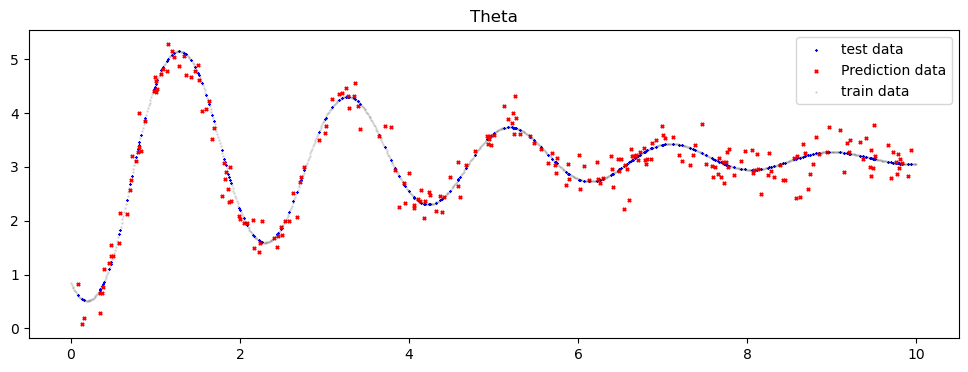

In [15]:
# theta is the latent state in this case
y2 = states[...,0, 0].view(-1,1)
# control inputs and accelerations are visible and measurable
x2 = torch.hstack([u.view(-1,1), accel.view(-1,2), states[...,1:4,0].view(-1,3)])

x_train2 = x2[train_idx]
y_train2 = y2[train_idx]
time_train = t_span[train_idx]

x_test2 = x2[test_idx] 
y_test2 = y2[test_idx]
time_test = t_span[test_idx]

print(x_train2.shape, x_test2.shape)
print(y_train2.shape, y_test2.shape)

reservoir2 = Reservoir(1000, lr=0.8, sr=0.8)
readout2 = Ridge(ridge=1e-7)

esn_model2 =  reservoir2 >> readout2
esn_model2 = esn_model2.fit(x_train2, y_train2)
prediction2 = esn_model2.run(x_test2)

prediction2 = esn_model2.run(x_test2)

plt.figure(figsize=(12,4))
plt.scatter(time_test,y_test2[...,0],color="blue",label="test data", marker='x',s=1)
plt.scatter(time_test,prediction2[...,0],color="red",label="Prediction data", marker='x',s=5)
plt.scatter(time_train,y_train2[...,0],color="black",label="train data",s=1, alpha=0.1)
plt.title("Theta"); plt.legend()